# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу NVBaranov_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (названия колонок + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение любых моделей машинного обучения из библиотеки sklearn.

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков (лучше выполнять действия сразу для двух датасетов)
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)

In [4]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'H:\\realestate\\train.csv'
TEST_DATASET_PATH = 'H:\\realestate\\test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df_var = pd.read_csv(TEST_DATASET_PATH)
display(train_df.tail())
print('Размеры: ', train_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.402,30.476,5.0,6,5.0,1968,0.136,B,B,46,7960,6,350.0,3,11,B,196684.316
9996,6159,18,1.0,41.522,20.539,9.0,13,13.0,2000,0.000,B,B,30,5562,0,NaN,0,5,A,189050.290
9997,5123,27,1.0,47.939,NaN,1.0,12,16.0,2015,0.072,B,B,2,629,1,NaN,0,0,A,159143.805
9998,5400,75,2.0,43.603,33.840,8.0,1,5.0,1961,0.307,B,A,30,5048,9,325.0,2,5,B,181595.340
9999,6306,128,1.0,38.667,21.158,8.0,7,17.0,1990,0.000,B,B,27,4798,0,30.0,2,8,B,218714.078


Размеры:  (10000, 20)


Проверка на наличие корреляций между числовыми значениями не дал явные зависимости.
Для сокращения времени вычисления всех команд в тетради закомментированы команды по построению графиков pairplot. Можно раскомментировать и построить парные графики.

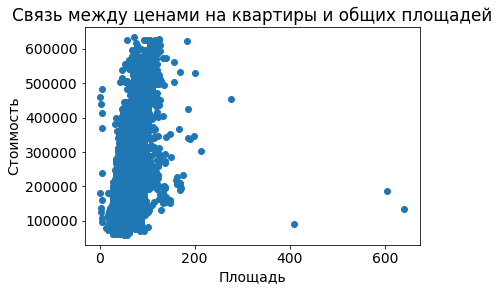

In [7]:
# df_num_features = train_df.select_dtypes(include='float64')
# sns.pairplot(df_num_features)

# Для примера показа связей приведен следующий график распределения между ценой и общей площади квартиры
# Возможно с правой стороны графика отображаются выбросы: площадь больше 400 стоят на уровне минимальных цен
plt.scatter(x=train_df['Square'], y=train_df['Price']);
plt.ylabel('Стоимость')
plt.xlabel('Площадь')
plt.title('Связь между ценами на квартиры и общих площадей')
plt.show()

**Проверяем на отличия в размерностях данных. <br />
В датасете train_df должно быть больше на один параметр (Price), чем в test_df**

In [8]:
train_df.shape[1]-1 == test_df_var.shape[1]

True

### Приведение типов

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
# перевод в категориальные переменные
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

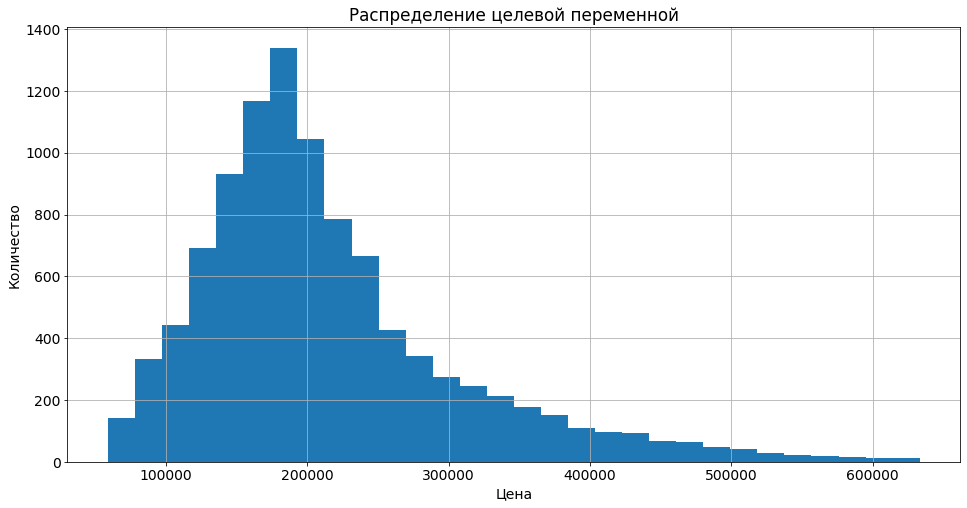

In [11]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Цена')
plt.title('Распределение целевой переменной')
plt.show()

**Количественные переменные**

In [12]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.891,0.840,0.000,1.000,2.000,2.000,1.900e+01
Square,10000.0,56.316,21.059,1.137,41.775,52.513,65.901,6.411e+02
LifeSquare,7887.0,37.200,86.241,0.371,22.770,32.781,45.129,7.481e+03
KitchenSquare,10000.0,6.273,28.561,0.000,1.000,6.000,9.000,2.014e+03
Floor,10000.0,8.527,5.241,1.000,4.000,7.000,12.000,4.200e+01
HouseFloor,10000.0,12.609,6.776,0.000,9.000,13.000,17.000,1.170e+02
HouseYear,10000.0,3990.166,200500.261,1910.000,1974.000,1977.000,2001.000,2.005e+07
Ecology_1,10000.0,0.119,0.119,0.000,0.018,0.075,0.196,5.219e-01
Social_1,10000.0,24.687,17.533,0.000,6.000,25.000,36.000,7.400e+01
Social_2,10000.0,5352.157,4006.800,168.000,1564.000,5285.000,7227.000,1.908e+04


**Категориальные переменные**

In [13]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [14]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

**Rooms**

In [15]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [16]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()
train_df.shape

(10000, 20)

**Square, LifeSquare, KitchenSquare**

In [17]:
LifeSquare_std = train_df['LifeSquare'].std()

In [18]:
steps = []
scores = [] # <- записываем финальный score

In [19]:
# steps.append('обработка выбросов Square')
train_df = train_df[train_df['Square'].isnull() | 
                   (train_df['Square'] < train_df['Square'].quantile(.99)) &
                   (train_df['Square'] > train_df['Square'].quantile(.01))]

In [20]:
# steps.append('обработка выбросов KitchenSquare')
train_df = train_df[train_df['KitchenSquare'].isnull() |
                   (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                   (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

**HouseFloor, Floor**

In [21]:
# 0-этаж - не будем считать как выброс. 
# Например, в США 0-этаж - это groundfloor и, соответственно, 2-этаж у них 1-м считается.
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

In [22]:
train_df['HouseYear'].sort_values().unique()

array([    1914,     1916,     1917,     1918,     1919,     1928,
           1929,     1930,     1931,     1932,     1933,     1934,
           1935,     1936,     1937,     1938,     1939,     1940,
           1941,     1942,     1947,     1948,     1950,     1951,
           1952,     1953,     1954,     1955,     1956,     1957,
           1958,     1959,     1960,     1961,     1962,     1963,
           1964,     1965,     1966,     1967,     1968,     1969,
           1970,     1971,     1972,     1973,     1974,     1975,
           1976,     1977,     1978,     1979,     1980,     1981,
           1982,     1983,     1984,     1985,     1986,     1987,
           1988,     1989,     1990,     1991,     1992,     1993,
           1994,     1995,     1996,     1997,     1998,     1999,
           2000,     2001,     2002,     2003,     2004,     2005,
           2006,     2007,     2008,     2009,     2010,     2011,
           2012,     2013,     2014,     2015,     2016,     2

In [23]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### Обработка пропусков

In [24]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4159
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [25]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.982,29.443,6.0
1,65.684,40.050,8.0
3,53.353,52.732,9.0
4,39.649,23.776,7.0
5,80.384,46.684,12.0
6,62.254,37.160,7.0
8,64.511,NaN,1.0
9,46.461,18.916,8.0
10,46.305,27.923,6.0
11,68.809,45.737,7.0


**LifeSquare**

In [26]:
# медиана до корректировки
train_df['LifeSquare'].median()

32.45708997289704

In [27]:
# медиана расхождения площадей
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    train_df.loc[train_df['LifeSquare'].isnull(), 'Square']
    - train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_med_diff*train_df.loc[train_df['LifeSquare'].isnull(), 'Square']/LifeSquare_std
)


In [28]:
train_df['LifeSquare'].median()

34.457169822623875

**Healthcare_1**

In [29]:
train_df['Healthcare_1'].head()

0       NaN
1     240.0
3    1084.0
4    2078.0
5     990.0
Name: Healthcare_1, dtype: float64

In [30]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков

**Dummies**

In [31]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})
train_df['HouseYear_decade'] = train_df['HouseYear']//10

**MedPriceByDistrict**

In [32]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                      .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.737
1,0,2.0,176210.812
2,0,3.0,300610.359
3,1,1.0,146341.760
4,1,2.0,202954.120


In [33]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,HouseYear_decade,MedPriceByDistrict
0,14038,35,2.0,47.982,29.443,6.0,7,9.0,1969,8.904e-02,B,B,33,7976,5,990.0,0,11,B,184966.931,1,1,1,196,203384.328
1,15053,41,3.0,65.684,40.050,8.0,7,9.0,1978,6.999e-05,B,B,46,10309,1,240.0,1,16,B,300009.450,1,1,1,197,300009.450
2,5809,58,2.0,53.353,52.732,9.0,8,17.0,1977,4.379e-01,B,B,23,5735,3,1084.0,0,5,B,175616.227,1,1,1,197,169246.116
3,10783,99,1.0,39.649,23.776,7.0,11,12.0,1976,1.234e-02,B,B,35,5776,1,2078.0,2,4,B,150226.532,1,1,1,197,158791.018
4,12915,59,3.0,80.384,46.684,12.0,5,17.0,2011,3.095e-01,B,B,35,7715,4,990.0,0,6,B,215898.448,1,1,1,201,384517.540


**MedPriceByHouseYear**

In [34]:
med_price_by_houseyear = train_df.groupby(['DistrictId', 'HouseYear_decade'], as_index=False).agg({'Price':'median'})\
                      .rename(columns={'Price':'MedPriceHouseYear'})
med_price_by_houseyear.head()

,DistrictId,HouseYear_decade,MedPriceHouseYear
0,0,195,221660.252
1,0,196,161569.916
2,0,197,162653.950
3,0,198,235450.619
4,0,200,359584.388


In [35]:
train_df = train_df.merge(med_price_by_houseyear, on=['DistrictId', 'HouseYear_decade'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,HouseYear_decade,MedPriceByDistrict,MedPriceHouseYear
0,14038,35,2.0,47.982,29.443,6.0,7,9.0,1969,8.904e-02,B,B,33,7976,5,990.0,0,11,B,184966.931,1,1,1,196,203384.328,194175.395
1,15053,41,3.0,65.684,40.050,8.0,7,9.0,1978,6.999e-05,B,B,46,10309,1,240.0,1,16,B,300009.450,1,1,1,197,300009.450,206811.797
2,5809,58,2.0,53.353,52.732,9.0,8,17.0,1977,4.379e-01,B,B,23,5735,3,1084.0,0,5,B,175616.227,1,1,1,197,169246.116,127976.459
3,10783,99,1.0,39.649,23.776,7.0,11,12.0,1976,1.234e-02,B,B,35,5776,1,2078.0,2,4,B,150226.532,1,1,1,197,158791.018,179064.635
4,12915,59,3.0,80.384,46.684,12.0,5,17.0,2011,3.095e-01,B,B,35,7715,4,990.0,0,6,B,215898.448,1,1,1,201,384517.540,215898.448


In [36]:
train_df['MedPriceHouseYear'].isnull().sum()

0

In [37]:
train_df['MedPriceByDistrict'].isnull().sum()

0

### Отбор признаков

In [38]:
train_df.columns.tolist()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9014 entries, 0 to 9013
Data columns (total 26 columns):
Id                    9014 non-null object
DistrictId            9014 non-null object
Rooms                 9014 non-null float64
Square                9014 non-null float64
LifeSquare            9014 non-null float64
KitchenSquare         9014 non-null float64
Floor                 9014 non-null int64
HouseFloor            9014 non-null float64
HouseYear             9014 non-null int64
Ecology_1             9014 non-null float64
Ecology_2             9014 non-null object
Ecology_3             9014 non-null object
Social_1              9014 non-null int64
Social_2              9014 non-null int64
Social_3              9014 non-null int64
Healthcare_1          9014 non-null float64
Helthcare_2           9014 non-null int64
Shops_1               9014 non-null int64
Shops_2               9014 non-null object
Price                 9014 non-null float64
Ecology_2_bin         9014 non-n

In [39]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'HouseYear_decade', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['MedPriceHouseYear', 'MedPriceByDistrict']

target_name = 'Price'

### Разбиение на train и val

In [40]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [42]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

**Отложенная выборка**

Train R2:	0.955
Valid R2:	0.761


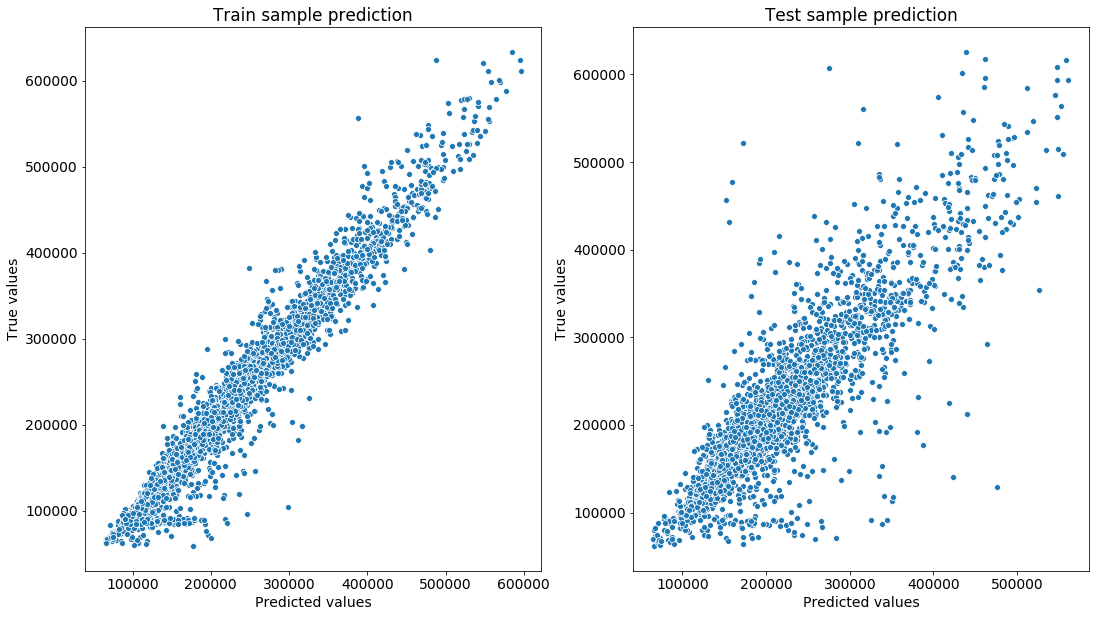

In [43]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [44]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.77314535, 0.73901145, 0.75079708])

In [45]:
cv_score.mean()

0.7543179584281479

### XGBoost

Train R2:	0.998
Valid R2:	0.791


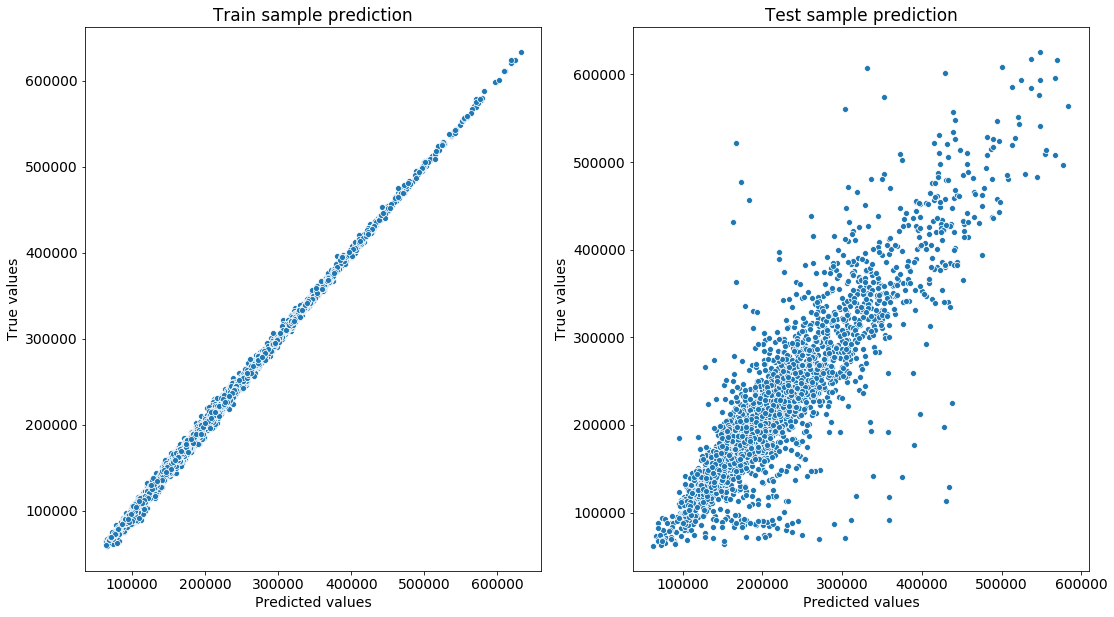

In [46]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=8, objective ='reg:squarederror')
xgb.fit(X_train, y_train)

y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [47]:
from sklearn.metrics import r2_score

In [48]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 
          'gamma':[i/10.0 for i in range(3,6)],  
          'subsample':[i/10.0 for i in range(6,11)],
          'max_depth': [2,3,4,7]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1, objective ='reg:squarederror') 

grid = GridSearchCV(xgb, params)
grid.fit(X_train,y_train) 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.3, 0.4, 0.5], 'max_depth': [2, 3, 4, 7],
                         'min_child

In [49]:
print(r2_score(y_test, grid.best_estimator_.predict(X_test)))

0.7992285722531948


Train R2:	0.836
Valid R2:	0.799


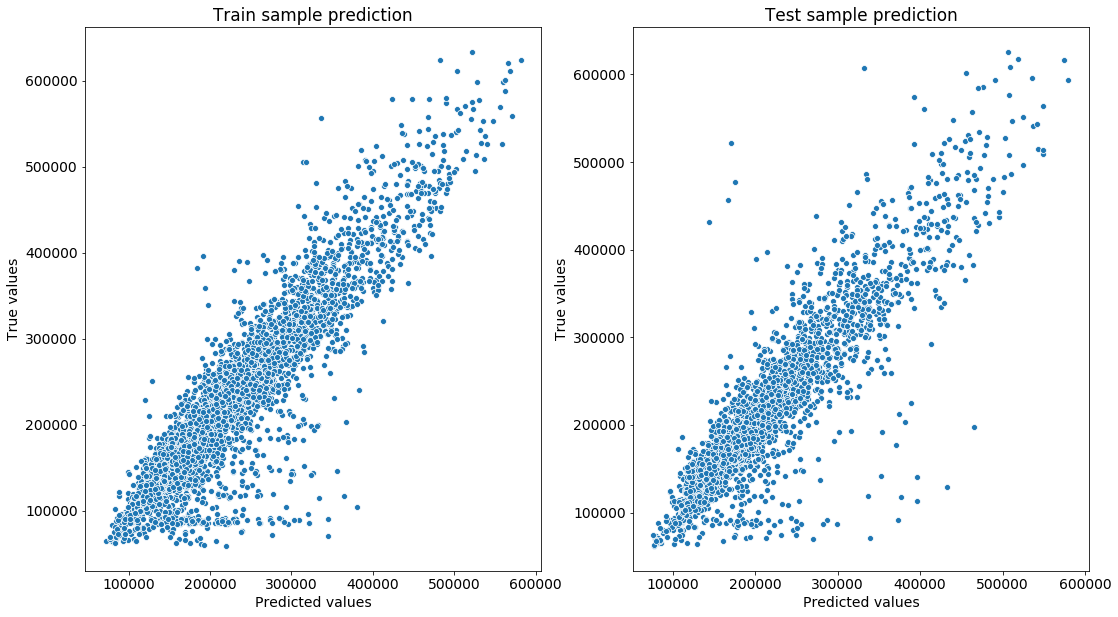

In [50]:
y_train_preds = grid.best_estimator_.predict(X_train)
y_test_preds = grid.best_estimator_.predict(X_test)


evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Важность признаков**

In [51]:
feature_importances = pd.DataFrame(zip(X_train.columns, grid.best_estimator_.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
19,MedPriceByDistrict,0.578
18,MedPriceHouseYear,0.111
1,Square,0.093
13,Social_3,0.028
3,KitchenSquare,0.025
11,Social_1,0.025
12,Social_2,0.019
14,Healthcare_1,0.017
4,Floor,0.016
15,Helthcare_2,0.015


# Работа с тестовым датасетом test_df

In [52]:
# чтение и получение краткой информации о составе данных
test_df = pd.read_csv(TEST_DATASET_PATH)
display(test_df.tail())
print(test_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.134,50.810,6.0,5,9.0,1973,1.697e-04,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198,21.807,10.0,12,17.0,2017,7.122e-03,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842,48.283,9.0,23,22.0,1989,9.080e-02,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305,NaN,0.0,4,0.0,1977,7.216e-02,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.556,NaN,1.0,10,17.0,1977,7.815e-05,B,B,22,6398,141,1046.0,3,23,B


(5000, 19)


### Приведение типов

In [53]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [54]:
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

**LifeSquare**

In [55]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    test_df.loc[test_df['LifeSquare'].isnull(), 'Square']
    - test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_med_diff*test_df.loc[test_df['LifeSquare'].isnull(), 'Square']/LifeSquare_std
)

**HealthCare_1**

In [56]:
# используем медиану для Healthcare_1 из train_df
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков
**dummies**

In [57]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})
test_df['HouseYear_decade'] = test_df['HouseYear']//10

**MedPriceByDistrict** - средняя цена квартир по районам в зависимости от количества комнат  <br />
**MedPriceHouseYear** - средняя цена квартир по районам в зависимости от года постройки

In [58]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_df = test_df.merge(med_price_by_houseyear, on=['DistrictId', 'HouseYear_decade'], how='left')
test_df.isnull().sum()

Id                      0
DistrictId              0
Rooms                   0
Square                  0
LifeSquare              0
KitchenSquare           0
Floor                   0
HouseFloor              0
HouseYear               0
Ecology_1               0
Ecology_2               0
Ecology_3               0
Social_1                0
Social_2                0
Social_3                0
Healthcare_1            0
Helthcare_2             0
Shops_1                 0
Shops_2                 0
Ecology_2_bin           0
Ecology_3_bin           0
Shops_2_bin             0
HouseYear_decade        0
MedPriceByDistrict     80
MedPriceHouseYear     145
dtype: int64

**MedPriceByDistrict и MedPriceHouseYear замена пустых значений медианой из train_df** <br/>
Количество пропусков MedPriceByDistrict = 80 и MedPriceHouseYear = 145 (степень влияния на предсказания: MedPriceByDistrict=0.578, MedPriceHouseYear=0.111). Из общего количества записей (5000) пропусков не так много. Попробуем заменить дополнительные признаки на медиану из train_df

In [59]:
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = train_df['MedPriceByDistrict'].median()
test_df.loc[test_df['MedPriceHouseYear'].isnull(), 'MedPriceHouseYear'] = train_df['MedPriceHouseYear'].median()

**Формируем тестовый набор, для которого нужно предсказать параметр Price**

In [60]:
X_exit = pd.get_dummies(test_df[feature_names + new_feature_names])

In [61]:
# Предсказание на основе модели grid.best_estimator_
test_df["Price"] = grid.best_estimator_.predict(X_exit)

In [62]:
# Выгрузка парных значений Id, Price для оценки
test_df.loc[:, ['Id', 'Price']].to_csv('EANesterov_predictions_2020.csv', index=False)